# DINO — Self-supervised representation learning (with segmentation capabilities)

[Emerging Properties in Self-Supervised Vision Transformers (Caron et al., 2021)](https://arxiv.org/abs/2104.14294)

[Отличное видео объяснение статьи](https://www.youtube.com/watch?v=h3ij3F3cPIk)

[vision_transformer](https://github.com/google-research/vision_transformer)

Для начала подгрузим модель DINO (self-**DI**stillation with **NO** labels)



In [ ]:
# fix random_seed
import torch
import random
import numpy as np

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Compute on cpu or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from IPython.display import clear_output

#!git clone https://github.com/facebookresearch/dino.git
!wget https://edunet.kea.su/repo/EduNet-web_dependencies/L12/dino.zip
!unzip dino.zip
clear_output()

## Сегментация изображений

Теперь загрузим случайную картинку (можно выбрать любую, просто замените ссылку на свою)

In [ ]:
URL = "https://edunet.kea.su/repo/EduNet-web_dependencies/L12/capybara_image.jpg"
!wget $URL -qO test.jpg

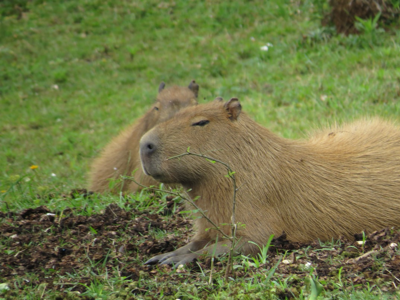

In [ ]:
from PIL import Image

input_img = Image.open("/content/test.jpg")
input_img.resize((400, 300))

Получим результат с помощью DINO

In [ ]:
!python /content/dino/visualize_attention.py --image_path /content/test.jpg 
clear_output()

Посмотрим на картинки, которые генерирует DINO

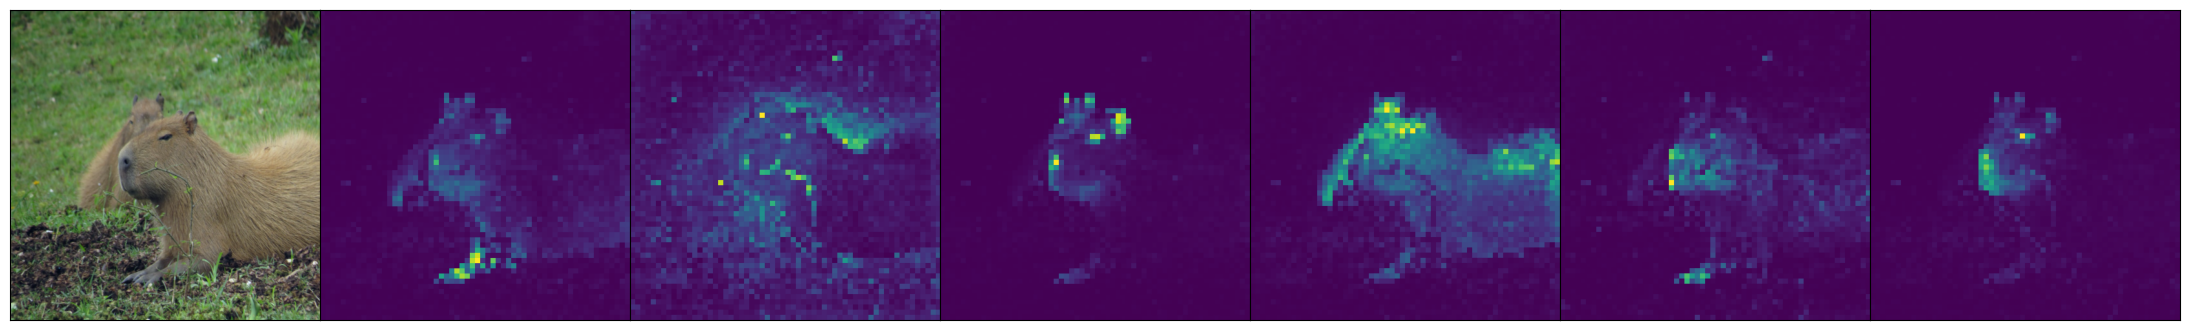

In [ ]:
from glob import glob
import matplotlib.pyplot as plt


def img_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(28, 8))
    for num, img in enumerate(imgs):
        img_PIL = Image.open(img)
        ax[num].imshow(img_PIL)
        ax[num].set_xticks([])
        ax[num].set_yticks([])
    plt.subplots_adjust(hspace=0, wspace=0)


img_grid(imgs=sorted(glob("*.png"))[::-1], rows=1, cols=7)
plt.show()

Мы видим 6 карт внимания (self-attention maps — веса слоя self-attention) на 6 головах Visual Transformer. В результате self-supervised обучения по методике DINO, трансформер САМОСТОЯТЕЛЬНО придумал обращать внимание на различные части изображения, таким образом производя семантическую сегментацию.

Мы можем все эти карты внимания объединить в одно изображение и просто назначить каждой карте свой цвет, а в качестве прозрачности использовать интенсивность

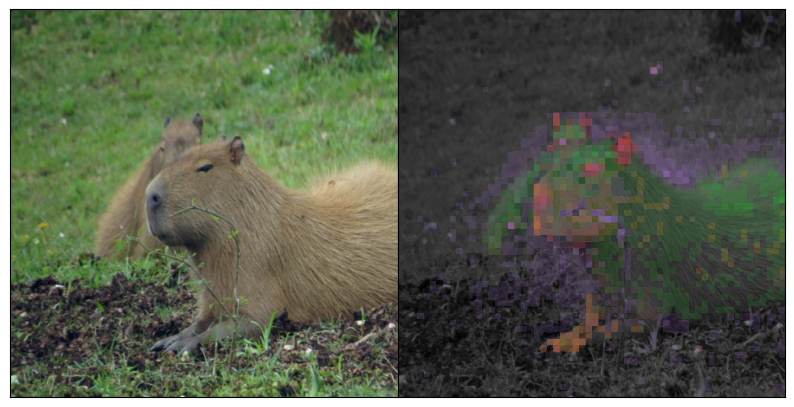

In [ ]:
import matplotlib.colors as mcolors
from matplotlib import cm


def overlay(img, segmentations):
    img_PIL = Image.open(img)
    fig, ax = plt.subplots(ncols=2, figsize=(10, 10))
    ax[0].imshow(img_PIL)
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    ax[1].imshow(img_PIL.convert("LA"), alpha=0.5)
    for num, img in enumerate(segmentations):
        segment_PIL = Image.open(img).convert("LA")
        segment_arr = np.array(segment_PIL)
        colors = [(*cm.tab10(num)[:-1], c) for c in np.linspace(0, 0.75, 100)]
        cmap = mcolors.LinearSegmentedColormap.from_list("mycmap", colors, N=5)
        ax[1].imshow(segment_arr[:, :, 0], cmap=cmap)
    ax[1].set_facecolor("black")
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    plt.subplots_adjust(hspace=0, wspace=0)


overlay("/content/img.png", sorted(glob("*.png"))[:-1])
plt.show()

Видим, что DINO сегментирует разные части нашей картинки на разные семантические группы. В случае с капибарой это голова, лицо (нос, глаза) и тело.

## Сегментация видео

Вы думали, что на этом все? Нет, DINO может еще удивить. Например, она умеет сегментировать видео.

In [ ]:
!sudo pip install --upgrade youtube_dl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.6 MB/s eta 0:00:00


Скачаем видео (можно любое):

In [ ]:
URL = "https://edunet.kea.su/repo/EduNet-web_dependencies/L12/cheetah_video.mp4"
!youtube-dl -o video.mp4 $URL

[generic] cheetah_video: Requesting header
[download] Destination: video.mp4
[download] 100% of 5.96MiB in 00:01


И сгенерируем сегментированное видео:

In [ ]:
!python /content/dino/video_generation.py --input_path /content/video.mp4 --output_path  /content/video_segmented --resize 360 640
!ffmpeg -i /content/video.mp4 -vf scale=640:360 /content/video_scaled.mp4
!ffmpeg \
  -i /content/video_scaled.mp4 \
  -i /content/video_segmented/video.mp4 \
  -filter_complex '[0:v]pad=iw*2:ih[int];[int][1:v]overlay=W/2:0[vid]' \
  -map '[vid]' \
  -c:v libx264 \
  -crf 23 \
  -preset veryfast \
  output.mp4

clear_output()
print('Complete')

Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.
Video: /content/video.mp4 (23.976023976023978 fps)
Extracting frames to /content/video_segmented/frames
Generating attention images to /content/video_segmented/attention
  0% 0/230 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference tr

Посмотрим, что получилось. Обратите внимание, эта сеть обучалась в режиме self-supervision!

In [ ]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open("/content/output.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(
    """
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
"""
    % data_url
)

## Кластеризация

А еще DINO умеет кластеризовать изображения. Выполнять не будем, так как процесс не быстрый, но можем посмотреть на результаты из их статьи

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/clustering_dino.gif" width="400">